# Twitter Sentiment Analysis with BERT

<img src="https://i.imgur.com/3tASSmp.jpg" width="700px">

This project is about the **analysis of tweets about coronavirus**, with the goal of performing a **Sentiment Analysis using BERT and ROBERTA ** algorithm to predict the emotion of a tweet (Positive, Negative or Neutral). In particular,  **BERT and will be fine tuned** using the given dataset in order to improve the model overall performance.<br>
Before feeding the data to the algorithms, **the tweets will be deeply cleaned to remove links, hashtags at the end of the sentences and punctuation** to allow the algorithms to better understand the text and improve the prediction performance.

### Installing and Importing Necessary Libraries

In [ ]:
pip install numpy pandas matplotlib seaborn tensorflow emoji nltk scikit-learn imbalanced-learn transformers

In [ ]:
pip install --upgrade matplotlib seaborn


In [ ]:
# General purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Transformers
from transformers import BertTokenizerFast, TFBertModel
from transformers import RobertaTokenizerFast, TFRobertaModel

# Keras
from tensorflow import keras

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)




## Custom functions definition:

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Loading the data

In [ ]:
df = pd.read_csv('/content/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/content/Corona_NLP_test.csv')

NOTE: UTF-8 encoding does not work on the dataset when loading it with pandas 'read_csv' function. This lead to the use of 'ISO-8859-1'/latin-1 encoding. <br>
It will be found later that some special characters like apostrophes are turned into '\x92', which will be taken care of during the data cleaning process.
                                                                                                         

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


We convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.

In [ ]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

<ipython-input-76-45b9b0fe6852>:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


## Duplicate tweets?

In [ ]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


Good news, No duplicate tweets !

# Tweets count by date

In [ ]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index()
tweets_per_day.columns = ['date', 'counts']  # Renaming for clarity


<ipython-input-80-63bc4561aec4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='date', y='counts', data=tweets_per_day, edgecolor='black', errorbar=('ci', False), palette='Blues_r')


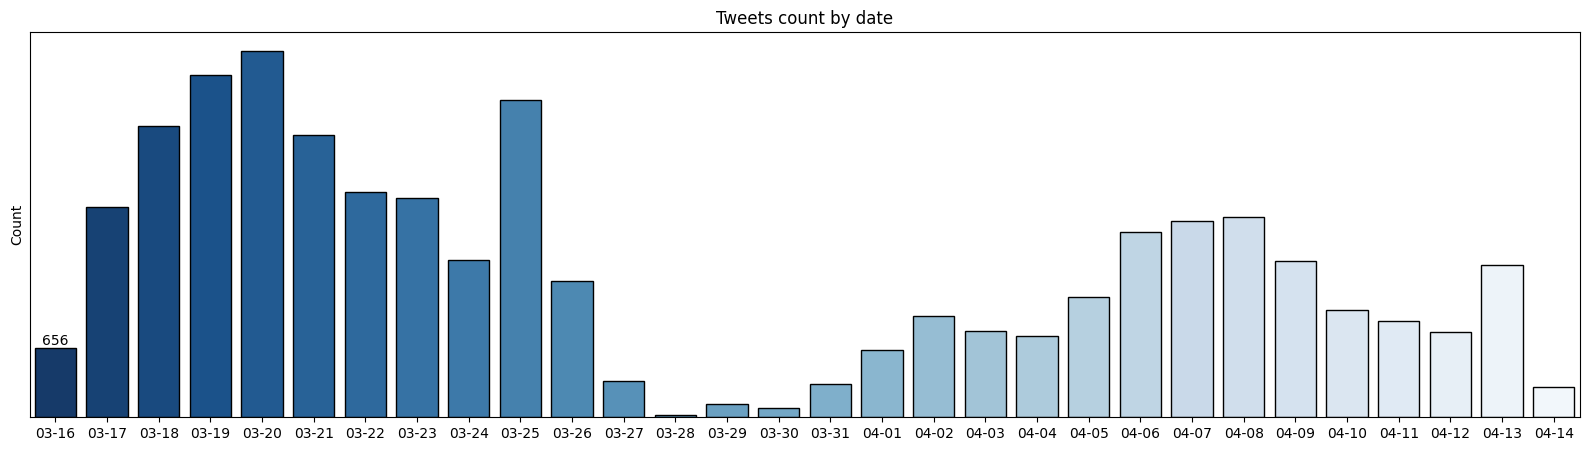

In [ ]:
plt.figure(figsize=(20, 5))
ax = sns.barplot(x='date', y='counts', data=tweets_per_day, edgecolor='black', errorbar=('ci', False), palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('')
plt.show()


We notice that in the dataset there are some days without tweets in the dataset. Among the days with tweets, most of them are made around the end of March: from 18th of Match to the 26th of March.

# Tweets per country and city

In [ ]:
tweets_per_country = df['Location'].value_counts().loc[lambda x: x > 100].reset_index()
tweets_per_country.columns = ['country', 'counts']  # Rename columns for clarity


<ipython-input-82-744b1c5b3519>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='country', y='counts', data=tweets_per_country, edgecolor='black', errorbar=('ci', False), palette='Blues_r')


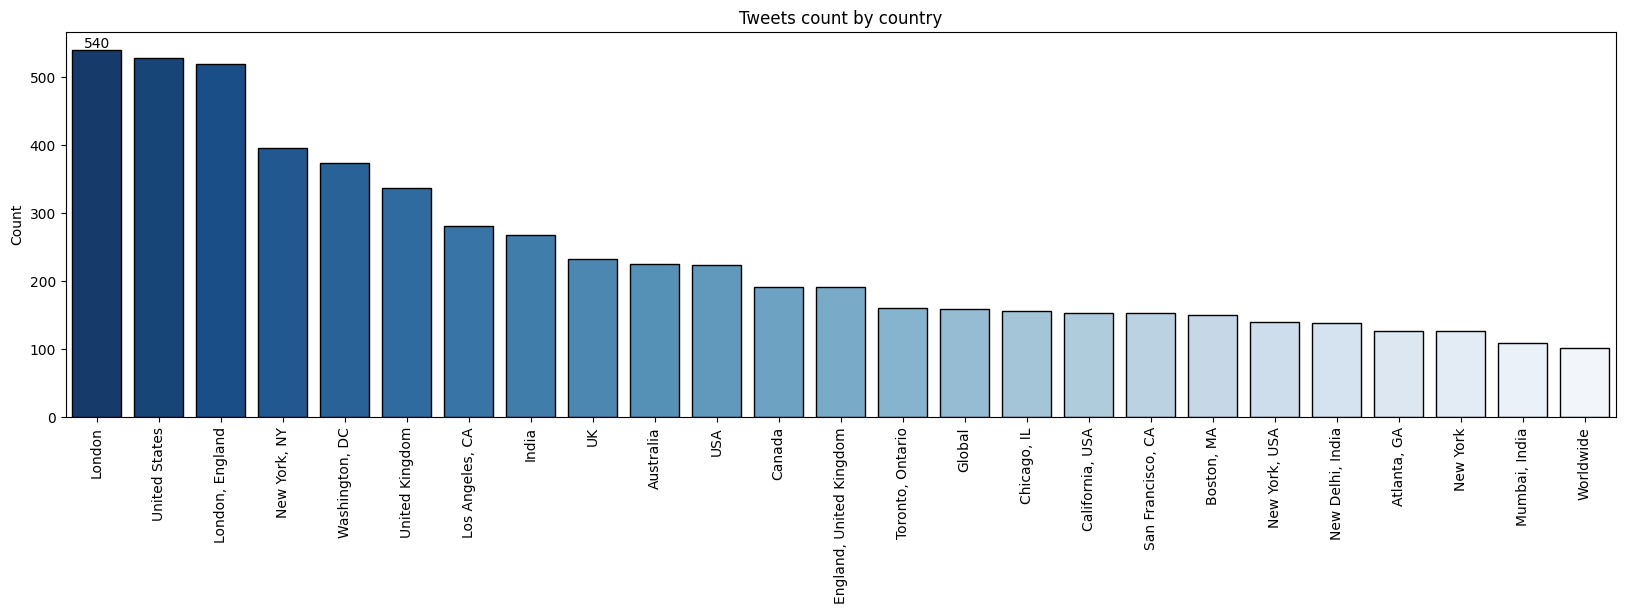

In [ ]:
plt.figure(figsize=(20, 5))
ax = sns.barplot(x='country', y='counts', data=tweets_per_country, edgecolor='black', errorbar=('ci', False), palette='Blues_r')
plt.title('Tweets count by country')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better readability
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('')
plt.show()


The 'location' column contains both countries and cities. It could be interesting to separate cities and countries, however this wont be investigated in this work.

In [ ]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,2020-04-14,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral


# Tweets Deep Cleaning

In the following, we will perform some data cleaning on the raw text of the tweets.<br>
To simplify the analaysis, we will just keep the columns 'Originaltweet' (raw tweets) and the target column 'Sentiment'.

In [ ]:
df = df[['OriginalTweet','Sentiment']]

In [ ]:
df_test = df_test[['OriginalTweet','Sentiment']]

**Then we define custom functions to clean the text of the tweets.**

In [ ]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
import re

# Clean emojis from text
def strip_emoji(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"  # other symbols
        "\U000024C2-\U0001F251"  # enclosed characters
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r"", text)

# Apply the updated function in your code
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


In [ ]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Now we can create a new column, for both train and test sets, to host the cleaned version of the tweets' text.

In [ ]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

<ipython-input-89-250c9d00a7e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = texts_new


In [ ]:
df['text_clean'].head()

,text_clean
0,and and
1,advice talk to your neighbours family to excha...
2,coronavirus australia woolworths to give elder...
3,my food stock is not the only one which is emp...
4,me ready to go at supermarket during the covid...


In [ ]:
df_test['text_clean'].head()

,text_clean
0,trending new yorkers encounter empty supermark...
1,when i couldnt find hand sanitizer at fred mey...
2,find out how you can protect yourself and love...
3,panic buying hits newyork city as anxious shop...
4,toiletpaper dunnypaper coronavirus coronavirus...


In [ ]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

Moreover, we will also create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
df_test['text_len'] = text_len_test

<ipython-input-40-6f9c3b55e95c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


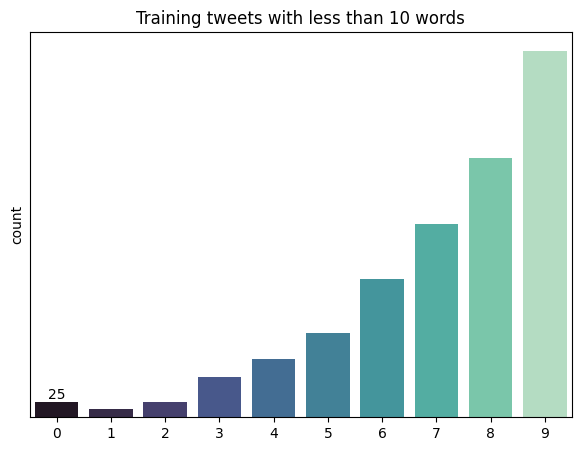

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

<ipython-input-41-7979c0899f38>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')


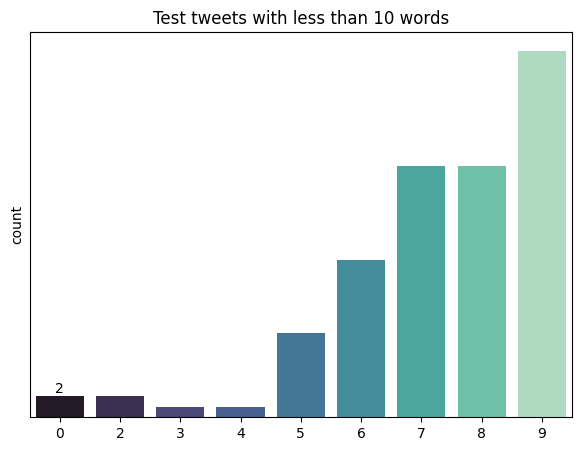

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [ ]:
df = df[df['text_len'] > 4]

In [ ]:
df_test = df_test[df_test['text_len'] > 4]

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


## Training data deeper cleaning

Let's perform a further cleaning checking the tokenizer version of the sentences.

First, we import the BERT tokenizer.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


Let's check the long tokenized sentences (with more than 80 tokens ):

In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

These sentences are not in english. They should be dropped.

In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [ ]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76


The dataset looks more clean now. We will shuffle it and reset the index.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data deeper cleaning

We will perform the data cleaning based on the tokenized sentences on the test set.

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


In [ ]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [ ]:
df_test['token_lens'] = token_lens_test

In [ ]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [ ]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

Now the data cleaning is completed. I will perform more data cleaning if I have new ideas !! :)

# Sentiment column analysis

Now we will look at the target column 'Sentiment'.

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,11381
Negative,9889
Neutral,7560
Extremely Positive,6618
Extremely Negative,5475


The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [ ]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
2,17999
0,15364
1,7560


We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [ ]:
train_os['Sentiment'].value_counts()

,count
Sentiment,
1,17999
0,17999
2,17999


## Train - Validation - Test split

In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

A validation set will be extracted from the training set to monitor the validation accuracy, and so prevent overfitting.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

## One hot encoding

After performing some tests, by using one hot encoding on the target variable we achieved higher accuracy. For this reason we will choose one hot enconding over label encoding. <br>
EDIT: We will save a copy of the label encoded target columns since they could be useful for further analysis.

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48597
VALIDATION DATA: 5400
TESTING DATA: 3787


# Baseline model: Naive Bayes Classifier

Before implementing BERT, we will define a simple Naive Bayes baseline model to classify the tweets.

First we need to tokenize the tweets using CountVectorizer.

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we create the TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized tweets.

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Now we can define the Naive Bayes Classifier model

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1629
     Neutral       0.58      0.44      0.50       614
    Positive       0.74      0.72      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.67      0.65      0.66      3787
weighted avg       0.70      0.70      0.70      3787



**The algorithm performance is not so bad. <br> The F1 score is around 70% for the more populated classes (Negative and Positive emotions), and lower for the Neutral class (F1=0.51).<br>
In particular, the overall accuracy is 70%.**

In the next section we will perform the sentiment analysis using BERT.

# RoBERTa Sentiment Analysis

As seen for BERT, we first import the tokenizer used to train the original roberta transformer by Facebook.

In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

First, we check the length of the longest tokenized sentence by roberta tokenizer:

In [ ]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

89

In [ ]:
MAX_LEN=128

Then we can define the tokenization function

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

# RoBERTa modeling

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    # Replace decay with weight_decay
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-7)  # Updated line
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model


In [ ]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_1[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=10, batch_size=32)

Epoch 1/10
1519/1519 [==============================] - 211s 114ms/step - loss: 0.5732 - categorical_accuracy: 0.7718 - val_loss: 0.3883 - val_categorical_accuracy: 0.8624
Epoch 2/10
1519/1519 [==============================] - 161s 106ms/step - loss: 0.3364 - categorical_accuracy: 0.8800 - val_loss: 0.3187 - val_categorical_accuracy: 0.8800
Epoch 3/10
1519/1519 [==============================] - 161s 106ms/step - loss: 0.2481 - categorical_accuracy: 0.9132 - val_loss: 0.2954 - val_categorical_accuracy: 0.9013
Epoch 4/10
1519/1519 [==============================] - 160s 106ms/step - loss: 0.1896 - categorical_accuracy: 0.9339 - val_loss: 0.2648 - val_categorical_accuracy: 0.9165
Epoch 5/10
1519/1519 [==============================] - 160s 106ms/step - loss: 0.1446 - categorical_accuracy: 0.9504 - val_loss: 0.2740 - val_categorical_accuracy: 0.9159
Epoch 6/10
1519/1519 [==============================] - 161s 106ms/step - loss: 0.1068 - categorical_accuracy: 0.9642 - val_loss: 0.2523 - v

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/My Drive/roberta_sentiment_analysis_model.h5')  # Make sure to adjust the path if needed


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/roberta_sentiment_analysis_model.h5',
                                          custom_objects={'TFRobertaModel': TFRobertaModel})
loaded_model.summary()  # Display the model architecture to confirm it loaded successfully


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_1[0][0]',             
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
new_data = ["The movie was super fantastic!", "I didn't like the food.", "It was okay, nothing special."]

input_ids, attention_masks = tokenize(new_data, max_len=MAX_LEN)

result = loaded_model.predict([input_ids, attention_masks])

y_pred = np.zeros_like(result)
y_pred[np.arange(len(y_pred)), result.argmax(1)] = 1

labels = ['Negative', 'Neutral', 'Positive']
for i, text in enumerate(new_data):
    sentiment = labels[np.argmax(y_pred[i])]
    print(f"Text: \"{text}\" --> Predicted Sentiment: {sentiment}")

1/1 [==============================] - 0s 44ms/step
Text: "The movie was super fantastic!" --> Predicted Sentiment: Positive
Text: "I didn't like the food." --> Predicted Sentiment: Negative
Text: "It was okay, nothing special." --> Predicted Sentiment: Neutral


# RoBERTa results

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 7s 39ms/step


In [ ]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [ ]:
result_roberta

array([[1.0097974e-03, 9.9803060e-01, 9.5954811e-04],
       [1.2702282e-02, 4.2628470e-01, 5.6101298e-01],
       [9.9999523e-01, 2.6735568e-06, 2.1292838e-06],
       ...,
       [9.8198950e-01, 9.3730595e-03, 8.6374283e-03],
       [7.5813106e-05, 7.3660691e-03, 9.9255812e-01],
       [9.9996746e-01, 1.2074609e-05, 2.0551339e-05]], dtype=float32)

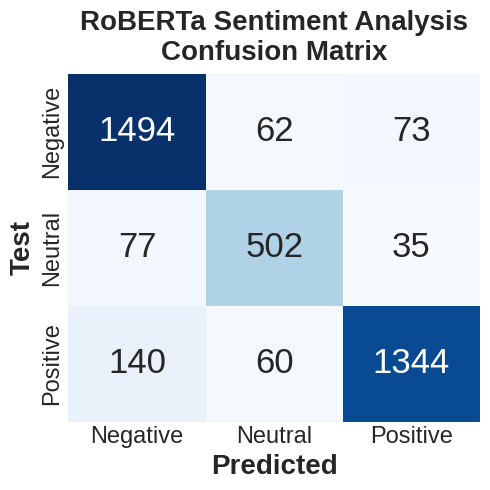

In [ ]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      1629
     Neutral       0.74      0.84      0.78       614
    Positive       0.92      0.88      0.90      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.85      0.87      0.86      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787



# BERT Sentiment Analysis

We already performed a basic analyis of the tokenized sentences, now we just need to define a custom tokenizer function and call the encode_plus method of the BERT tokenizer.

In [ ]:
MAX_LEN=128

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Then, we apply the tokenizer function to the train, validation and test sets.

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# BERT modeling

Now we can import the BERT model from the pretrained library from Hugging face.

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# pip install tensorflow==2.16.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.16.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.16.0


Then, we create a custom function to host the pre trained BERT model, and attach to it a 3 neurons output layer, necessary to perform the classification of the 3 different classes of the dataset (the 3 emotions).

In [ ]:
import tensorflow as tf
from transformers import TFBertModel

# Define a custom Keras layer to wrap the BERT model
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Pass inputs to BERT model and get the pooled output
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs[1]  # We take the pooled output (index 1)

# Create the model
def create_model(bert_model, max_len=MAX_LEN):
    # Optimizer, loss, and metrics
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Define the input layers
    input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # Use the custom BertLayer to wrap the BERT model
    bert_output = BertLayer(bert_model)([input_ids, attention_masks])

    # Add a Dense layer for classification
    output = tf.keras.layers.Dense(3, activation="softmax")(bert_output)

    # Create and compile the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

# Load the pre-trained BERT model (you can choose other variants)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Create the model
model = create_model(bert_model, MAX_LEN)

# Model summary
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_layer (BertLayer)      (None, 768)                  1094822   ['input_ids[0][0]',           
                                                          40         'attention_mask[0][0]']      
                                                                                              

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=10, batch_size=32)

Epoch 1/10
1519/1519 [==============================] - 347s 204ms/step - loss: 0.5513 - categorical_accuracy: 0.7817 - val_loss: 0.3758 - val_categorical_accuracy: 0.8598
Epoch 2/10
1519/1519 [==============================] - 291s 192ms/step - loss: 0.2904 - categorical_accuracy: 0.8971 - val_loss: 0.2727 - val_categorical_accuracy: 0.8985
Epoch 3/10
1519/1519 [==============================] - 289s 190ms/step - loss: 0.1929 - categorical_accuracy: 0.9336 - val_loss: 0.2307 - val_categorical_accuracy: 0.9181
Epoch 4/10
1519/1519 [==============================] - 293s 193ms/step - loss: 0.1280 - categorical_accuracy: 0.9565 - val_loss: 0.2400 - val_categorical_accuracy: 0.9280
Epoch 5/10
1519/1519 [==============================] - 284s 187ms/step - loss: 0.0853 - categorical_accuracy: 0.9722 - val_loss: 0.2507 - val_categorical_accuracy: 0.9326
Epoch 6/10
1519/1519 [==============================] - 283s 186ms/step - loss: 0.0560 - categorical_accuracy: 0.9819 - val_loss: 0.2197 - v

In [ ]:
import torch

# Save the model weights
torch.save(model.state_dict(), 'bert_model_weights.pth')

print("Model weights saved successfully.")


Model weights saved successfully.


In [ ]:
# Load the model weights
model.load_state_dict(torch.load('bert_model_weights.pth'))

# Set the model to evaluation mode (if you're going to perform inference)
model.eval()

print("Model weights loaded successfully.")


Model weights loaded successfully.


# BERT results

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 14s 92ms/step


In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

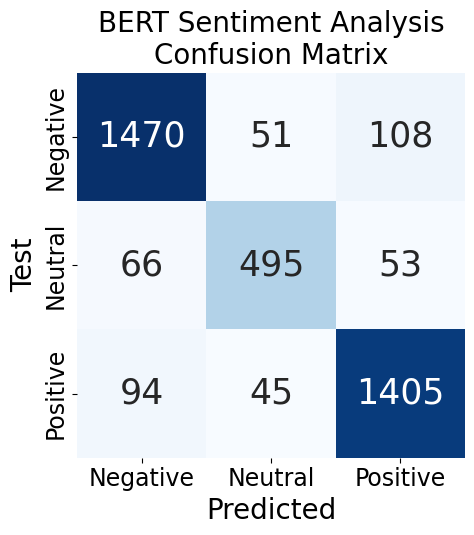

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      1629
     Neutral       0.84      0.81      0.82       614
    Positive       0.90      0.91      0.90      1544

   micro avg       0.89      0.89      0.89      3787
   macro avg       0.88      0.87      0.88      3787
weighted avg       0.89      0.89      0.89      3787
 samples avg       0.89      0.89      0.89      3787



# Results Summary

## Classification Matrix Comparison

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()

##Fine-Tuning

1.Prompt Engineering

Steps :

1. Split Data into Train and Validation Sets

2. Initialize the Tokenizer

3. Add Prompt to Tweets

4. Apply Prompt Engineering to the Data

5. Tokenize the Prompted Texts

6. Map Sentiment Labels to Numeric Values

7. Convert Labels to PyTorch Tensors

8. Create DataLoader for Efficient Batch Processing



Key Points:

1. Prompt Engineering: Adds additional context to each tweet to guide the model in sentiment analysis.

2. Tokenizer: Prepares text input into the format expected by BERT (tokenized and padded).

3. Sentiment Label Mapping: Converts sentiment labels from text to numeric form.

4. DataLoader: Efficiently loads data in batches during training.

5. Model Training: Implements a typical training loop with forward passes, loss calculation, backpropagation, and optimization.

In [ ]:
df

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
0,Latest coronavirus update from me for Thursday...,1,latest coronavirus update from me for thursday...,9,12
1,Try and think about this stuff\r\r\nSanitizers...,0,try and think about this stuff sanitizers are ...,41,60
2,Update from Belgium on Lockdown since 30 mins ...,1,update from belgium on lockdown since 30 mins ...,49,53
3,Aquilo que venho a sofrer desde Janeiro &gt;&g...,2,aquilo que venho a sofrer desde janeiro gtgtgt...,16,29
4,"Well, hello there ?\r\r\n#COVID?19 #coronaviru...",2,well hello there covid19 coronavirus toiletpap...,8,20
...,...,...,...,...,...
40918,"Exclusive: Debenhams, which has furloughed the...",2,exclusive debenhams which has furloughed the v...,39,52
40919,@drharshvardhan @MoHFW_INDIA - As National Tas...,0,as national task force for covid19 recommends ...,35,47
40920,Consumer Reports Opposes Efforts to Delay CCPA...,0,consumer reports opposes efforts to delay ccpa...,11,16
40921,Amazon and eBay failing to stop Covid-19 profi...,1,amazon and ebay failing to stop covid19 profit...,30,61


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score

# Load the dataset
train_data = df[['text_clean', 'Sentiment']]

# Split into train and validation sets
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Map sentiment labels to numeric values
sentiment_mapping = {
    'Extremely Positive': 4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative': 0
}
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)
valid_data['Sentiment'] = valid_data['Sentiment'].map(sentiment_mapping)

# Tokenization function
def tokenize_data(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Prepare datasets
def prepare_dataloader(data, tokenizer, batch_size=8):
    texts = data['text_clean'].tolist()
    labels = torch.tensor(data['Sentiment'].values, dtype=torch.long)
    encodings = tokenize_data(texts, tokenizer)

    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Training function
def train_model(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader)

# Validation function
def evaluate_model(model, valid_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [item.to(device) for item in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Prepare DataLoaders
train_loader = prepare_dataloader(train_data, tokenizer)
valid_loader = prepare_dataloader(valid_data, tokenizer)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, device)
    valid_accuracy = evaluate_model(model, valid_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {valid_accuracy:.4f}")

print("Model training completed.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1
Train Loss: 0.7957
Validation Accuracy: 0.7595
Model training completed.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Import tqdm for progress bars

# Load and split dataset
data = df[['text_clean', 'Sentiment']]
train_data, valid_data = train_test_split(data, test_size=0.1, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Map sentiment labels to numeric values
sentiment_mapping = {
    'Extremely Positive': 4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative': 0
}
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)
valid_data['Sentiment'] = valid_data['Sentiment'].map(sentiment_mapping)

# Prompt engineering: Add task-specific instructions to each text
def add_prompt(text):
    return f"Classify the sentiment of this sentence: {text}"

train_data['text_clean'] = train_data['text_clean'].apply(add_prompt)
valid_data['text_clean'] = valid_data['text_clean'].apply(add_prompt)

# Tokenization function
def tokenize_data(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Prepare datasets
def prepare_dataloader(data, tokenizer, batch_size=8):
    texts = data['text_clean'].tolist()
    labels = torch.tensor(data['Sentiment'].values, dtype=torch.long)
    encodings = tokenize_data(texts, tokenizer)

    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Training function with fine-tuning techniques and tqdm
def train_model(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training", leave=False):  # Wrap train_loader with tqdm
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate

    return total_loss / len(train_loader)

# Validation function with tqdm
def evaluate_model(model, valid_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Evaluating", leave=False):  # Wrap valid_loader with tqdm
            input_ids, attention_mask, labels = [item.to(device) for item in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Initialize model, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
train_loader = prepare_dataloader(train_data, tokenizer)
valid_loader = prepare_dataloader(valid_data, tokenizer)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training l1op with fine-tuning, prompt engineering, and progress tracking
num_epochs = 1
best_accuracy = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, scheduler, device)
    valid_accuracy = evaluate_model(model, valid_loader, device)

    # Save the model with best validation accuracy
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {valid_accuracy:.4f}")

print("Model training completed.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Train Loss: 0.7253
Validation Accuracy: 0.8387
Model training completed.


example

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def save_model(model, tokenizer, path="/content/drive/MyDrive/prompt_model"):
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    print("Model and tokenizer saved successfully.")
save_model(model, tokenizer, "/content/drive/MyDrive/prompt_model")

Model and tokenizer saved successfully.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model and tokenizer from saved files
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/prompt_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/prompt_model")
model.eval()  # Set model to evaluation mode

# Sample input text for testing
sample_text = "The product quality is excellent, and I'm very satisfied with the purchase!"

# Preprocess the input with the prompt engineering step
sample_text = add_prompt(sample_text)

# Tokenize the input text
inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move inputs to the correct device
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

# Predict sentiment
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    prediction = torch.argmax(outputs.logits, dim=-1).item()

# Map numeric prediction back to sentiment label
reverse_sentiment_mapping = {v: k for k, v in sentiment_mapping.items()}
predicted_sentiment = reverse_sentiment_mapping[prediction]

# Print result
print(f"Input text: {sample_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")


Input text: Classify the sentiment of this sentence: The product quality is excellent, and I'm very satisfied with the purchase!
Predicted Sentiment: Extremely Positive


2.Prompt Tuning

Steps:

1. Create Learnable Prompt Embeddings: Initialize a small set of learnable prompt tokens.

2. Concatenate Prompt Tokens with Input Embeddings: Concatenate the prompt tokens to the input text embeddings.

3. Train the Model: Only update the prompt embeddings while keeping the main model frozen.

Key Components:

1. Learnable Prompt Embeddings: prompt_embeddings is an embedding layer with prompt_length tokens, which are concatenated with input embeddings.

2. Custom Forward Function: The forward_with_prompt function concatenates prompt embeddings with the input embeddings and adjusts the attention mask.

3. Training the Prompt Embeddings Only: We freeze the main model weights and only update prompt_embeddings in each training step. This allows tuning of the soft prompts without altering the model itself.

In [ ]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Load and split dataset
data = df[['text_clean', 'Sentiment']]
train_data, valid_data = train_test_split(data, test_size=0.1, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Map sentiment labels to numeric values
sentiment_mapping = {
    'Extremely Positive': 4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative': 0
}
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)
valid_data['Sentiment'] = valid_data['Sentiment'].map(sentiment_mapping)

# Tokenization function
def tokenize_data(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Prepare datasets
def prepare_dataloader(data, tokenizer, batch_size=8):
    texts = data['text_clean'].tolist()
    labels = torch.tensor(data['Sentiment'].values, dtype=torch.long)
    encodings = tokenize_data(texts, tokenizer)

    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Define soft prompt tuning class
class PromptTuningModel(nn.Module):
    def __init__(self, model_name, num_labels, prompt_length=10):
        super(PromptTuningModel, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.prompt_embeddings = nn.Embedding(prompt_length, self.model.config.hidden_size)

        # Initialize the soft prompt embeddings
        nn.init.normal_(self.prompt_embeddings.weight, mean=0.0, std=0.02)

        self.prompt_length = prompt_length

    def forward(self, input_ids, attention_mask, labels=None):
        # Get input embeddings from model
        inputs_embeds = self.model.base_model.embeddings(input_ids)

        # Create prompt embeddings and concatenate with input embeddings
        prompt_embeds = self.prompt_embeddings.weight.unsqueeze(0).repeat(inputs_embeds.size(0), 1, 1)
        inputs_embeds = torch.cat([prompt_embeds, inputs_embeds], dim=1)

        # Adjust attention mask to account for prompt embeddings
        attention_mask = torch.cat(
            [torch.ones((attention_mask.size(0), self.prompt_length), dtype=attention_mask.dtype, device=attention_mask.device),
             attention_mask], dim=1)

        # Forward pass through the model
        outputs = self.model(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels)
        return outputs

# Initialize model, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PromptTuningModel('bert-base-uncased', num_labels=5).to(device)
optimizer = AdamW([
    {'params': model.model.parameters(), 'lr': 5e-5},
    {'params': model.prompt_embeddings.parameters(), 'lr': 1e-3}  # Higher learning rate for prompt tuning
])
train_loader = prepare_dataloader(train_data, tokenizer)
valid_loader = prepare_dataloader(valid_data, tokenizer)
num_epochs = 1
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training function with prompt tuning
def train_model(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training", leave=False):
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(train_loader)

# Validation function
def evaluate_model(model, valid_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Evaluating", leave=False):
            input_ids, attention_mask, labels = [item.to(device) for item in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Training loop with prompt tuning and fine-tuning
best_accuracy = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, scheduler, device)
    valid_accuracy = evaluate_model(model, valid_loader, device)

    # Save the model with best validation accuracy
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), "best_prompt_tuned_model.pt")

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {valid_accuracy:.4f}")

print("Model training with prompt tuning completed.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Train Loss: 0.7415
Validation Accuracy: 0.8239
Model training with prompt tuning completed.


In [ ]:
import os
def save_model(model, tokenizer, path="/content/drive/MyDrive/prompt_tuning_model"):
    # Save model weights (state_dict)
    os.makedirs(path, exist_ok=True)

    torch.save(model.state_dict(), f"{path}/model_state_dict.pth")

    # Save the tokenizer
    tokenizer.save_pretrained(path)

# Save the model and tokenizer after training
save_model(model, tokenizer)


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the saved model and tokenizer
model_path = "/content/drive/MyDrive/prompt_tuning_model"
model = PromptTuningModel('bert-base-uncased', num_labels=5).to(device)
model.load_state_dict(torch.load(f"{model_path}/model_state_dict.pth"))
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Function to predict sentiment of a text input
def predict_sentiment(text, model, tokenizer, device):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

    with torch.no_grad():  # No need to compute gradients for inference
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Map prediction back to sentiment label
    sentiment_mapping_inv = {v: k for k, v in sentiment_mapping.items()}
    predicted_sentiment = sentiment_mapping_inv[predicted_class]

    return predicted_sentiment

# Test the model with a new text input
test_text = "I absolutely love this product! It works wonders."
predicted_sentiment = predict_sentiment(test_text, model, tokenizer, device)

print(f"Predicted Sentiment: {predicted_sentiment}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Sentiment: Extremely Positive


example

3.PEFT (Parameter-Efficient Fine-Tuning)

Steps:

1. Add Adapter Layers: Insert small trainable layers (adapters) into each transformer layer.

2. freeze the Main Model: Only the adapter layers are updated during training.

3. Train the Model Efficiently: This reduces memory usage and enables more efficient task adaptation.

Key Points:

1. Adapter Layers: Small trainable layers added within the transformer model, defined by AdapterConfig.

2. Freezing Main Model: Only adapter layers are trained while the rest of the model is frozen, making it efficient for tasks with limited data or computational power.

3. Reduction Factor: Controls the size of adapters. A lower reduction factor results in more parameters within the adapter, improving task performance but using more resources.

In [ ]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from peft import get_peft_model, LoraConfig, TaskType
import os

# Enable CUDA error debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Load and split dataset
data = df[['text_clean', 'Sentiment']]
train_data, valid_data = train_test_split(data, test_size=0.1, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Map sentiment labels to numeric values
sentiment_mapping = {
    'Extremely Positive': 4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative': 0
}
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)
valid_data['Sentiment'] = valid_data['Sentiment'].map(sentiment_mapping)

# Tokenization function
def tokenize_data(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Prepare datasets
def prepare_dataloader(data, tokenizer, batch_size=8):
    texts = data['text_clean'].tolist()
    labels = torch.tensor(data['Sentiment'].values, dtype=torch.long)  # Ensure labels are tensor
    encodings = tokenize_data(texts, tokenizer)

    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Initialize LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=8,  # Low-rank factor
    lora_alpha=32,  # Scaling factor for LoRA
    lora_dropout=0.1,  # Dropout for LoRA
)

# Initialize model and apply LoRA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)
model = get_peft_model(model, lora_config)  # Apply LoRA after loading the model

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
train_loader = prepare_dataloader(train_data, tokenizer)
valid_loader = prepare_dataloader(valid_data, tokenizer)
num_epochs = 1
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training function with LoRA fine-tuning
def train_model(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training", leave=False):
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(train_loader)

# Validation function
def evaluate_model(model, valid_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Evaluating", leave=False):
            input_ids, attention_mask, labels = [item.to(device) for item in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Training loop with LoRA fine-tuning
best_accuracy = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, scheduler, device)
    valid_accuracy = evaluate_model(model, valid_loader, device)

    # Save the model with best validation accuracy
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), "best_lora_tuned_model.pt")

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {valid_accuracy:.4f}")

print("Model training with LoRA fine-tuning completed.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
save_model(model, tokenizer, "/content/drive/MyDrive/peft_model")

example

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model and tokenizer from saved files
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/peft_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/peft_model")
model.eval()  # Set model to evaluation mode

# Sample input text for testing
sample_text = "The product quality is excellent, and I'm very satisfied with the purchase!"

# Preprocess the input with the prompt engineering step
sample_text = add_prompt(sample_text)

# Tokenize the input text
inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move inputs to the correct device
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

# Predict sentiment
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    prediction = torch.argmax(outputs.logits, dim=-1).item()

# Map numeric prediction back to sentiment label
reverse_sentiment_mapping = {v: k for k, v in sentiment_mapping.items()}
predicted_sentiment = reverse_sentiment_mapping[prediction]

# Print result
print(f"Input text: {sample_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")


4.RLHF (Reinforcement Learning from Human Feedback)

RLHF Workflow:

1. Training a Reward Model: Use human feedback to train a reward model that scores responses based on human preferences.

2. Generating Responses: Fine-tune a model with reinforcement learning to maximize the reward from the reward model.

3. Policy Optimization: Optimize the policy using Proximal Policy Optimization (PPO), a popular RL algorithm for text-based applications.

For this code, we’ll use Hugging Face’s trl library, which includes tools for applying RL techniques like PPO to language models.

Key Parts of the Code:

1. Prepare Prompts: Converts tweets into prompts suitable for text generation.

2. Define Reward Model: A rule-based reward function (placeholder) that assigns a reward based on sentiment alignment. For a more robust setup, a separate reward model can be trained.

3. PPO Trainer Setup: The PPO trainer from trl uses policy optimization to adjust model outputs based on rewards.

4. Training Loop: For each epoch, the model generates responses to prompts, and PPO adjusts the responses to maximize rewards.